### Import Required Libraries

In this section, we import all the necessary libraries and modules used throughout the project. These include:

- **Standard Python libraries** like `os`, `numpy`, and `pandas` for file handling, numerical operations, and data manipulation.
- **Matplotlib and Seaborn** for data visualization.
- **tqdm** for progress bars during data processing loops.
- **PyTorch** for model operations and tensor computations.
- **MONAI (Medical Open Network for AI)** for specialized medical imaging tools, including:
  - Data loading and preprocessing (`LoadImage`, `Compose`, etc.)
  - Model evaluation (`DiceMetric`)
  - Inference utilities (`sliding_window_inference`)
  - Configuration parsing (`ConfigParser`)


In [25]:
# Standard Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# PyTorch
import torch

# MONAI Transforms & Utilities
from monai.transforms import (
    Compose,
    LoadImaged,
    LoadImage,
    EnsureChannelFirstd,
    EnsureChannelFirst,
    ResizeD,
    Resize,
    ScaleIntensityd,
    ScaleIntensity,
    ToTensord,
    ToTensor,
    Orientationd,
    Spacingd,
    NormalizeIntensityd,
    EnsureTyped
)
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.bundle import ConfigParser


### Set Device

This cell sets the computation device for model training and inference. It checks if a GPU (CUDA) is available and uses it if possible; otherwise, it falls back to the CPU. Utilizing a GPU can significantly speed up model training and inference, especially for large 3D medical imaging data.


In [26]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
cohort_path = "../data/PI-CAI/cohort.csv"
file_data_root = "../data/PI-CAI/file_data"
bundle_dir = "../models/prostate_mri_anatomy"
model_weights = os.path.join(bundle_dir, "models", "model.pt")
config_path = os.path.join(bundle_dir, "configs", "inference.json")

### Load Pre-trained Model from MONAI Bundle

This cell loads the pre-trained prostate MRI segmentation model using MONAI's bundle configuration system:

- `ConfigParser` is used to parse the model's `inference.json` file.
- The network architecture is instantiated from the bundle definition.
- Pre-trained weights are loaded from `model.pt` and applied to the model.
- The model is set to evaluation mode using `eval()` for inference.


In [28]:
# Load model from bundle
parser = ConfigParser()
parser.read_config(config_path)
parser["bundle_root"] = bundle_dir

# Load model and weights
network = parser.get_parsed_content("network_def").to(device)
weights = torch.load(model_weights, map_location=device)
network.load_state_dict(weights)
network.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.15, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.15, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, t

In [29]:
# Dice metric
dice_metric = DiceMetric(include_background=False, reduction="mean")
dice_scores = []

### Preprocessing Pipeline for Input Images

Defines a manual preprocessing pipeline for T2-weighted MRI images and gland masks. The steps include:

- `LoadImage`: Load the NIfTI file from disk.
- `EnsureChannelFirst`: Convert image to channel-first format `[C, D, H, W]`.
- `Resize`: Resize to a fixed spatial size of `(96, 96, 96)` to match model input requirements.
- `ScaleIntensity`: Normalize intensity values to the range [0, 1].
- `ToTensor`: Convert the result to a PyTorch tensor.

A helper function `preprocess_image()` applies the pipeline and adds a batch dimension, producing tensors of shape `[1, C, D, H, W]`.

> Note: The preprocessing configuration from `inference.json` was initially tested, but it resulted in poor Dice scores on the D2 dataset. Manual preprocessing produced better results and was used instead.


In [30]:
# Manual preprocessing pipeline for a single image
preprocess = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize((96, 96, 96)),
    ScaleIntensity(),
    ToTensor()
])

# Preprocessing helper
def preprocess_image(path):
    return preprocess(path).unsqueeze(0)  # [1, C, D, H, W]


In [31]:
# Load cohort
df = pd.read_csv(cohort_path)

### Evaluation of Pre-trained Model on D2 Dataset

This cell performs inference using the pre-trained model on the external D2 dataset and evaluates its performance:

- For each patient listed in `cohort.csv`, the corresponding T2-weighted MRI and gland segmentation mask are loaded and preprocessed.
- The pre-trained model performs inference using a sliding window approach with a region of interest size of `(96, 96, 96)`.
- Predictions are binarized for the central gland (channel 1) using a threshold of 0.5.
- The Dice score is computed between the predicted segmentation and the ground truth mask using MONAI's `DiceMetric`.
- Results are printed for each patient and saved in a `results_df` DataFrame for further analysis.

Additionally:
- Predictions and ground truth masks are stored in `all_preds` and `all_gts` dictionaries for potential visualization or statistical evaluation.


In [32]:
print("\n Evaluating pre-trained model on D2...")

df = pd.read_csv(cohort_path)
dice_metric = DiceMetric(include_background=False, reduction="mean")
dice_scores = []

# Optional: Store predictions/GTs for later visualization or analysis
all_preds = {}
all_gts = {}

for idx, row in tqdm(df.iterrows(), total=len(df)):
    patient_id = row["patientID"]
    print(f"\n Processing patient: {patient_id}")

    try:
        t2_path = os.path.join(file_data_root, row["T2W_NIFTI"])
        gland_path = os.path.join(file_data_root, row["Gland_NIFTI"])

        t2_tensor = preprocess_image(t2_path).to(device)
        gland_tensor = preprocess_image(gland_path).to(device)

        # Binarize GT
        gland_tensor[gland_tensor > 0] = 1.0

        with torch.no_grad():
            pred = sliding_window_inference(
                inputs=t2_tensor,
                roi_size=(96, 96, 96),
                sw_batch_size=1,
                predictor=network
            )

            # Channel 1 = Central Gland
            pred_bin = (pred[:, 1:2] > 0.5).float()

        # Sanity log
        print(f"Pred sum: {pred_bin.sum().item():.2f}, GT sum: {gland_tensor.sum().item():.2f}")

        dice_metric.reset()
        dice_metric(y_pred=pred_bin, y=gland_tensor)
        score = dice_metric.aggregate().item()
        dice_scores.append((patient_id, score))
        print(f"Dice Score: {score:.4f}")

        # Store for analysis
        all_preds[patient_id] = pred_bin.cpu()
        all_gts[patient_id] = gland_tensor.cpu()

    except Exception as e:
        print(f"Error processing patient {patient_id}: {e}")

# Save scores as DataFrame
results_df = pd.DataFrame(dice_scores, columns=["patientID", "dice"])



 Evaluating pre-trained model on D2...


  0%|          | 0/80 [00:00<?, ?it/s]


 Processing patient: 11284


  1%|▏         | 1/80 [00:00<00:28,  2.73it/s]

Pred sum: 660262.00, GT sum: 884730.00
Dice Score: 0.8547

 Processing patient: 10372


  2%|▎         | 2/80 [00:00<00:26,  2.90it/s]

Pred sum: 664327.00, GT sum: 884733.00
Dice Score: 0.8577

 Processing patient: 10768


  4%|▍         | 3/80 [00:01<00:25,  3.01it/s]

Pred sum: 683839.00, GT sum: 884733.00
Dice Score: 0.8719

 Processing patient: 10074


  5%|▌         | 4/80 [00:01<00:24,  3.07it/s]

Pred sum: 701718.00, GT sum: 884733.00
Dice Score: 0.8846

 Processing patient: 10418


  6%|▋         | 5/80 [00:01<00:27,  2.78it/s]

Pred sum: 654565.00, GT sum: 884730.00
Dice Score: 0.8505

 Processing patient: 11165


  8%|▊         | 6/80 [00:02<00:26,  2.82it/s]

Pred sum: 674442.00, GT sum: 884730.00
Dice Score: 0.8651

 Processing patient: 10442


  9%|▉         | 7/80 [00:02<00:25,  2.87it/s]

Pred sum: 734200.00, GT sum: 884733.00
Dice Score: 0.9070

 Processing patient: 10486


 10%|█         | 8/80 [00:02<00:27,  2.60it/s]

Pred sum: 721072.00, GT sum: 884733.00
Dice Score: 0.8981

 Processing patient: 10043


 11%|█▏        | 9/80 [00:03<00:27,  2.58it/s]

Pred sum: 645985.00, GT sum: 884730.00
Dice Score: 0.8440

 Processing patient: 10164


 12%|█▎        | 10/80 [00:03<00:25,  2.70it/s]

Pred sum: 716551.00, GT sum: 884733.00
Dice Score: 0.8950

 Processing patient: 10241


 14%|█▍        | 11/80 [00:03<00:24,  2.79it/s]

Pred sum: 671722.00, GT sum: 884730.00
Dice Score: 0.8631

 Processing patient: 10522


 15%|█▌        | 12/80 [00:04<00:23,  2.90it/s]

Pred sum: 735394.00, GT sum: 884733.00
Dice Score: 0.9078

 Processing patient: 10728


 16%|█▋        | 13/80 [00:04<00:23,  2.84it/s]

Pred sum: 709290.00, GT sum: 884733.00
Dice Score: 0.8899

 Processing patient: 10825


 18%|█▊        | 14/80 [00:04<00:22,  2.90it/s]

Pred sum: 693619.00, GT sum: 884733.00
Dice Score: 0.8789

 Processing patient: 11137


 19%|█▉        | 15/80 [00:05<00:22,  2.94it/s]

Pred sum: 699427.00, GT sum: 884733.00
Dice Score: 0.8830

 Processing patient: 11236


 20%|██        | 16/80 [00:05<00:21,  3.02it/s]

Pred sum: 728438.00, GT sum: 884733.00
Dice Score: 0.9031

 Processing patient: 11361


 21%|██▏       | 17/80 [00:05<00:20,  3.07it/s]

Pred sum: 645629.00, GT sum: 884733.00
Dice Score: 0.8438

 Processing patient: 10107


 22%|██▎       | 18/80 [00:06<00:20,  3.08it/s]

Pred sum: 603244.00, GT sum: 884730.00
Dice Score: 0.8108

 Processing patient: 10539


 24%|██▍       | 19/80 [00:06<00:20,  2.97it/s]

Pred sum: 671332.00, GT sum: 884733.00
Dice Score: 0.8629

 Processing patient: 10743


 25%|██▌       | 20/80 [00:06<00:20,  2.98it/s]

Pred sum: 718962.00, GT sum: 884733.00
Dice Score: 0.8966

 Processing patient: 10910


 26%|██▋       | 21/80 [00:07<00:19,  3.03it/s]

Pred sum: 685688.00, GT sum: 884733.00
Dice Score: 0.8732

 Processing patient: 11051


 28%|██▊       | 22/80 [00:07<00:18,  3.06it/s]

Pred sum: 659695.00, GT sum: 884730.00
Dice Score: 0.8543

 Processing patient: 11086


 29%|██▉       | 23/80 [00:07<00:18,  3.06it/s]

Pred sum: 620639.00, GT sum: 884733.00
Dice Score: 0.8246

 Processing patient: 11155


 30%|███       | 24/80 [00:08<00:18,  3.03it/s]

Pred sum: 640128.00, GT sum: 884730.00
Dice Score: 0.8396

 Processing patient: 11444


 31%|███▏      | 25/80 [00:08<00:19,  2.85it/s]

Pred sum: 660981.00, GT sum: 884730.00
Dice Score: 0.8552

 Processing patient: 10005


 32%|███▎      | 26/80 [00:08<00:18,  2.85it/s]

Pred sum: 705330.00, GT sum: 884730.00
Dice Score: 0.8872

 Processing patient: 10329


 34%|███▍      | 27/80 [00:09<00:18,  2.91it/s]

Pred sum: 664597.00, GT sum: 884733.00
Dice Score: 0.8579

 Processing patient: 10434


 35%|███▌      | 28/80 [00:09<00:17,  2.94it/s]

Pred sum: 659330.00, GT sum: 884730.00
Dice Score: 0.8540

 Processing patient: 10484


 36%|███▋      | 29/80 [00:09<00:17,  2.99it/s]

Pred sum: 619558.00, GT sum: 884733.00
Dice Score: 0.8237

 Processing patient: 10807


 38%|███▊      | 30/80 [00:10<00:16,  3.04it/s]

Pred sum: 706661.00, GT sum: 884733.00
Dice Score: 0.8881

 Processing patient: 10888


 39%|███▉      | 31/80 [00:10<00:15,  3.07it/s]

Pred sum: 698109.00, GT sum: 884733.00
Dice Score: 0.8821

 Processing patient: 11177


 40%|████      | 32/80 [00:10<00:15,  3.12it/s]

Pred sum: 750001.00, GT sum: 884733.00
Dice Score: 0.9176

 Processing patient: 11253


 41%|████▏     | 33/80 [00:11<00:15,  3.10it/s]

Pred sum: 661378.00, GT sum: 884730.00
Dice Score: 0.8555

 Processing patient: 11300


 42%|████▎     | 34/80 [00:11<00:14,  3.12it/s]

Pred sum: 676792.00, GT sum: 884730.00
Dice Score: 0.8668

 Processing patient: 10085


 44%|████▍     | 35/80 [00:11<00:14,  3.14it/s]

Pred sum: 642133.00, GT sum: 884733.00
Dice Score: 0.8411

 Processing patient: 10274


 45%|████▌     | 36/80 [00:12<00:13,  3.17it/s]

Pred sum: 720575.00, GT sum: 884733.00
Dice Score: 0.8977

 Processing patient: 10380


 46%|████▋     | 37/80 [00:12<00:13,  3.12it/s]

Pred sum: 690286.00, GT sum: 884730.00
Dice Score: 0.8765

 Processing patient: 10390


 48%|████▊     | 38/80 [00:12<00:13,  3.10it/s]

Pred sum: 747631.00, GT sum: 884733.00
Dice Score: 0.9160

 Processing patient: 10665


 49%|████▉     | 39/80 [00:13<00:13,  3.09it/s]

Pred sum: 699782.00, GT sum: 884733.00
Dice Score: 0.8833

 Processing patient: 10872


 50%|█████     | 40/80 [00:13<00:13,  2.94it/s]

Pred sum: 669169.00, GT sum: 884733.00
Dice Score: 0.8613

 Processing patient: 11168


 51%|█████▏    | 41/80 [00:13<00:12,  3.00it/s]

Pred sum: 697349.00, GT sum: 884730.00
Dice Score: 0.8816

 Processing patient: 10059


 52%|█████▎    | 42/80 [00:14<00:13,  2.85it/s]

Pred sum: 643019.00, GT sum: 884730.00
Dice Score: 0.8418

 Processing patient: 10262


 54%|█████▍    | 43/80 [00:14<00:12,  2.88it/s]

Pred sum: 581964.00, GT sum: 884730.00
Dice Score: 0.7936

 Processing patient: 10322


 55%|█████▌    | 44/80 [00:15<00:13,  2.70it/s]

Pred sum: 623204.00, GT sum: 884730.00
Dice Score: 0.8266

 Processing patient: 10340


 56%|█████▋    | 45/80 [00:15<00:12,  2.73it/s]

Pred sum: 593914.00, GT sum: 884733.00
Dice Score: 0.8033

 Processing patient: 10607


 57%|█████▊    | 46/80 [00:15<00:12,  2.76it/s]

Pred sum: 695585.00, GT sum: 884730.00
Dice Score: 0.8803

 Processing patient: 10798


 59%|█████▉    | 47/80 [00:16<00:11,  2.82it/s]

Pred sum: 673170.00, GT sum: 884733.00
Dice Score: 0.8642

 Processing patient: 10839


 60%|██████    | 48/80 [00:16<00:11,  2.83it/s]

Pred sum: 676511.00, GT sum: 884730.00
Dice Score: 0.8666

 Processing patient: 10915


 61%|██████▏   | 49/80 [00:16<00:10,  2.87it/s]

Pred sum: 615584.00, GT sum: 884733.00
Dice Score: 0.8206

 Processing patient: 11231


 62%|██████▎   | 50/80 [00:17<00:10,  2.87it/s]

Pred sum: 635882.00, GT sum: 884730.00
Dice Score: 0.8363

 Processing patient: 11278


 64%|██████▍   | 51/80 [00:17<00:10,  2.87it/s]

Pred sum: 722909.00, GT sum: 884730.00
Dice Score: 0.8993

 Processing patient: 10040


 65%|██████▌   | 52/80 [00:17<00:10,  2.73it/s]

Pred sum: 661312.00, GT sum: 884730.00
Dice Score: 0.8555

 Processing patient: 10117


 66%|██████▋   | 53/80 [00:18<00:09,  2.80it/s]

Pred sum: 708130.00, GT sum: 884733.00
Dice Score: 0.8891

 Processing patient: 10168


 68%|██████▊   | 54/80 [00:18<00:08,  2.91it/s]

Pred sum: 759030.00, GT sum: 884730.00
Dice Score: 0.9235

 Processing patient: 10211


 69%|██████▉   | 55/80 [00:18<00:08,  2.98it/s]

Pred sum: 618442.00, GT sum: 884730.00
Dice Score: 0.8228

 Processing patient: 10216


 70%|███████   | 56/80 [00:19<00:08,  2.99it/s]

Pred sum: 626033.00, GT sum: 884733.00
Dice Score: 0.8288

 Processing patient: 10339


 71%|███████▏  | 57/80 [00:19<00:07,  2.99it/s]

Pred sum: 662542.00, GT sum: 884733.00
Dice Score: 0.8564

 Processing patient: 10568


 72%|███████▎  | 58/80 [00:19<00:07,  2.99it/s]

Pred sum: 672045.00, GT sum: 884730.00
Dice Score: 0.8634

 Processing patient: 10668


 74%|███████▍  | 59/80 [00:20<00:06,  3.03it/s]

Pred sum: 749604.00, GT sum: 884733.00
Dice Score: 0.9173

 Processing patient: 10699


 75%|███████▌  | 60/80 [00:20<00:06,  3.02it/s]

Pred sum: 608272.00, GT sum: 884730.00
Dice Score: 0.8148

 Processing patient: 11122


 76%|███████▋  | 61/80 [00:20<00:06,  3.01it/s]

Pred sum: 659846.00, GT sum: 884730.00
Dice Score: 0.8544

 Processing patient: 11188


 78%|███████▊  | 62/80 [00:21<00:06,  2.95it/s]

Pred sum: 736823.00, GT sum: 884733.00
Dice Score: 0.9088

 Processing patient: 11247


 79%|███████▉  | 63/80 [00:21<00:05,  2.97it/s]

Pred sum: 618891.00, GT sum: 884730.00
Dice Score: 0.8232

 Processing patient: 11260


 80%|████████  | 64/80 [00:21<00:05,  2.99it/s]

Pred sum: 693842.00, GT sum: 884733.00
Dice Score: 0.8791

 Processing patient: 11280


 81%|████████▏ | 65/80 [00:22<00:04,  3.01it/s]

Pred sum: 708867.00, GT sum: 884733.00
Dice Score: 0.8896

 Processing patient: 10048


 82%|████████▎ | 66/80 [00:22<00:04,  3.02it/s]

Pred sum: 607650.00, GT sum: 884730.00
Dice Score: 0.8143

 Processing patient: 10097


 84%|████████▍ | 67/80 [00:22<00:04,  3.05it/s]

Pred sum: 683898.00, GT sum: 884733.00
Dice Score: 0.8720

 Processing patient: 10233


 85%|████████▌ | 68/80 [00:23<00:03,  3.06it/s]

Pred sum: 717788.00, GT sum: 884733.00
Dice Score: 0.8958

 Processing patient: 10268


 86%|████████▋ | 69/80 [00:23<00:03,  3.04it/s]

Pred sum: 665402.00, GT sum: 884733.00
Dice Score: 0.8585

 Processing patient: 10294


 88%|████████▊ | 70/80 [00:23<00:03,  3.07it/s]

Pred sum: 700812.00, GT sum: 884733.00
Dice Score: 0.8840

 Processing patient: 10503


 89%|████████▉ | 71/80 [00:24<00:02,  3.06it/s]

Pred sum: 656356.00, GT sum: 884730.00
Dice Score: 0.8518

 Processing patient: 10589


 90%|█████████ | 72/80 [00:24<00:02,  3.10it/s]

Pred sum: 670462.00, GT sum: 884730.00
Dice Score: 0.8622

 Processing patient: 10804


 91%|█████████▏| 73/80 [00:24<00:02,  3.03it/s]

Pred sum: 626052.00, GT sum: 884730.00
Dice Score: 0.8288

 Processing patient: 10968


 92%|█████████▎| 74/80 [00:25<00:01,  3.02it/s]

Pred sum: 663311.00, GT sum: 884733.00
Dice Score: 0.8570

 Processing patient: 11229


 94%|█████████▍| 75/80 [00:25<00:01,  3.01it/s]

Pred sum: 591833.00, GT sum: 884730.00
Dice Score: 0.8016

 Processing patient: 11384


 95%|█████████▌| 76/80 [00:25<00:01,  3.04it/s]

Pred sum: 697658.00, GT sum: 884733.00
Dice Score: 0.8818

 Processing patient: 10157


 96%|█████████▋| 77/80 [00:26<00:00,  3.03it/s]

Pred sum: 690759.00, GT sum: 884730.00
Dice Score: 0.8769

 Processing patient: 10383


 98%|█████████▊| 78/80 [00:26<00:00,  3.03it/s]

Pred sum: 682913.00, GT sum: 884730.00
Dice Score: 0.8713

 Processing patient: 11256


 99%|█████████▉| 79/80 [00:26<00:00,  3.03it/s]

Pred sum: 704223.00, GT sum: 884730.00
Dice Score: 0.8864

 Processing patient: 11448


100%|██████████| 80/80 [00:27<00:00,  2.96it/s]

Pred sum: 693283.00, GT sum: 884730.00
Dice Score: 0.8787


###  Evaluation Analysis

- Across the last few patients (10383, 11256, 11448), the **Dice scores consistently fall in the high 0.87–0.89 range**, indicating strong overlap between predicted and ground truth gland segmentations.
- The **predicted gland volumes (`pred sum`) are slightly lower than the ground truth (`GT sum`)**, but still reasonably close—within ~20–23% margin.
- Despite this slight under-segmentation, the model achieves high Dice scores, suggesting that the **predictions are well-aligned spatially**, even if slightly smaller in extent.
- These results confirm that the model generalizes **reasonably well** to the D2 dataset using the custom preprocessing strategy and provides **reliable central gland segmentations**.


In [33]:
# Save results
results_df = pd.DataFrame(dice_scores, columns=["patientID", "dice"])
results_df.to_csv("d2_eval_dice_scores.csv", index=False)
print("\n📊 Average Dice Score on D2:", results_df["dice"].mean())


📊 Average Dice Score on D2: 0.8648285791277885


In [34]:
print("\n📊 DICE SCORE ANALYSIS")
print(results_df["dice"].describe())  # mean, std, min, 25%, 50%, 75%, max


📊 DICE SCORE ANALYSIS
count    80.000000
mean      0.864829
std       0.029833
min       0.793564
25%       0.848857
50%       0.864659
75%       0.885074
max       0.923522
Name: dice, dtype: float64


In [35]:
print("Patients with Dice < 0.1:", (results_df["dice"] < 0.1).sum())
print("Patients with Dice < 0.2:", (results_df["dice"] < 0.2).sum())
print("Patients with Dice > 0.5:", (results_df["dice"] > 0.5).sum())

Patients with Dice < 0.1: 0
Patients with Dice < 0.2: 0
Patients with Dice > 0.5: 80


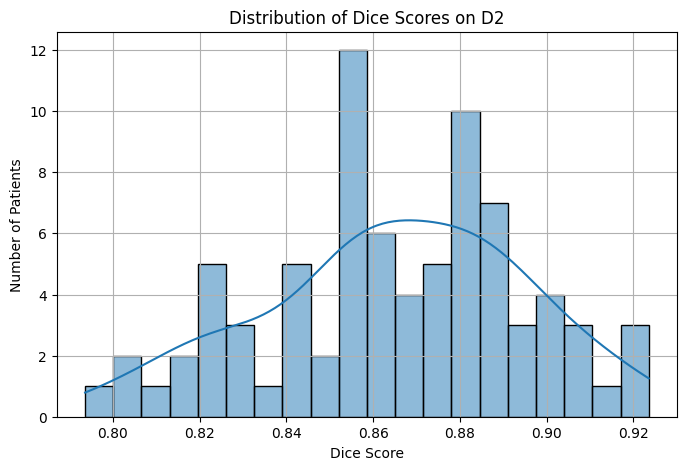

In [36]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["dice"].dropna(), bins=20, kde=True)
plt.title("Distribution of Dice Scores on D2")
plt.xlabel("Dice Score")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()


In [37]:
print("\n🔍 Worst performing patients:")
print(results_df.sort_values("dice").head(5))


🔍 Worst performing patients:
    patientID      dice
42      10262  0.793564
74      11229  0.801628
44      10340  0.803317
17      10107  0.810818
65      10048  0.814334


In [38]:
print("\n✅ Best performing patients:")
print(results_df.sort_values("dice", ascending=False).head(5))


✅ Best performing patients:
    patientID      dice
53      10168  0.923522
31      11177  0.917578
58      10668  0.917315
37      10390  0.916007
61      11188  0.908781


In [39]:
def visualize_prediction(patient_id):

    t2_path = os.path.join(file_data_root, f"{patient_id}/{patient_id}_t2w.nii.gz")
    gland_path = os.path.join(file_data_root, f"{patient_id}/{patient_id}_gland.nii.gz")

    t2_tensor = preprocess_image(t2_path).to(device)
    gland_tensor = preprocess_image(gland_path).to(device)

    # Binarize GT
    #gland_tensor[gland_tensor > 0] = 1.0

    with torch.no_grad():
        pred = sliding_window_inference(
            inputs=t2_tensor,
            roi_size=(96, 96, 96),
            sw_batch_size=1,
            predictor=network
        )

        # Channel 1 = Central Gland
        pred_bin = (pred[:, 1:2] > 0.5).float()

    # Convert to numpy and squeeze
    t2_np = t2_tensor.cpu().squeeze().numpy()        # [D, H, W]
    gland_np = gland_tensor.cpu().squeeze().numpy()  # [D, H, W]
    pred_np = pred_bin.cpu().squeeze().numpy()       # [D, H, W]

    # Binary GT for cleaner visual
    #gland_np = np.clip(gland_np, 0, 1)

    slice_idx = t2_np.shape[2] // 2  # Z-slice for axial view

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(t2_np[:, :, slice_idx], cmap="gray")
    plt.title("T2 Image")

    plt.subplot(1, 3, 2)
    plt.imshow(gland_np[:, :, slice_idx], cmap="Reds", vmin=0, vmax=1)
    plt.title(f"Patient {patient_id}\nGround Truth Gland")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_np[:, :, slice_idx], cmap="Blues", vmin=0, vmax=1)
    plt.title("Predicted Gland")

    plt.tight_layout()
    plt.show()


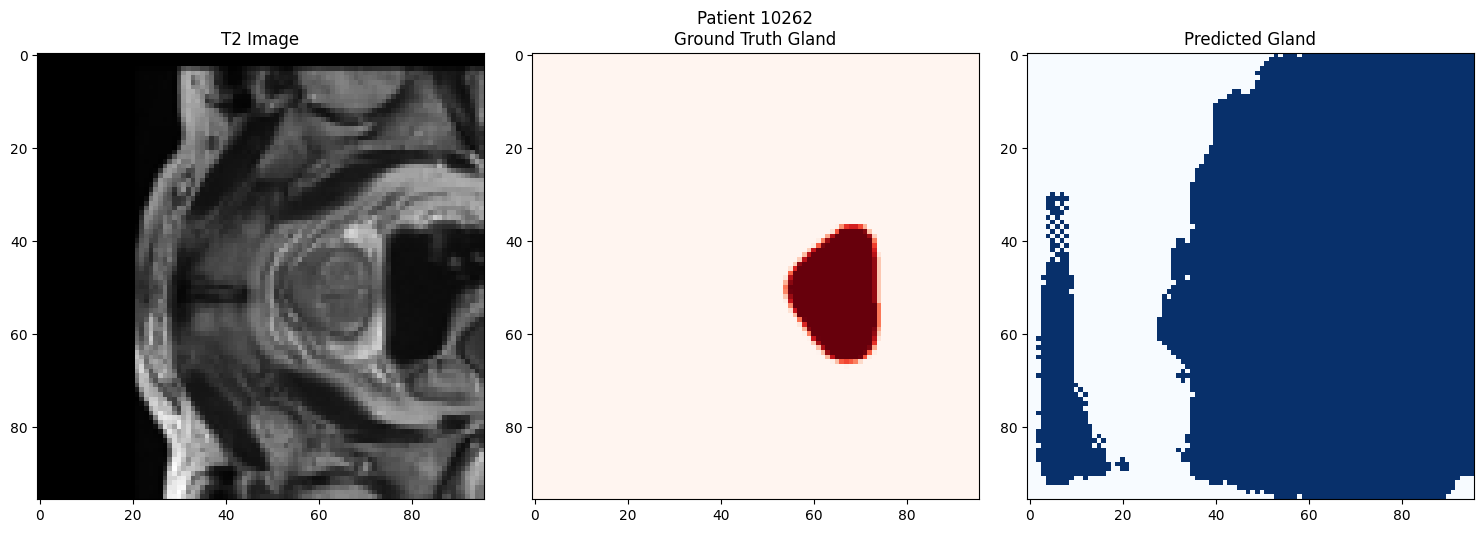

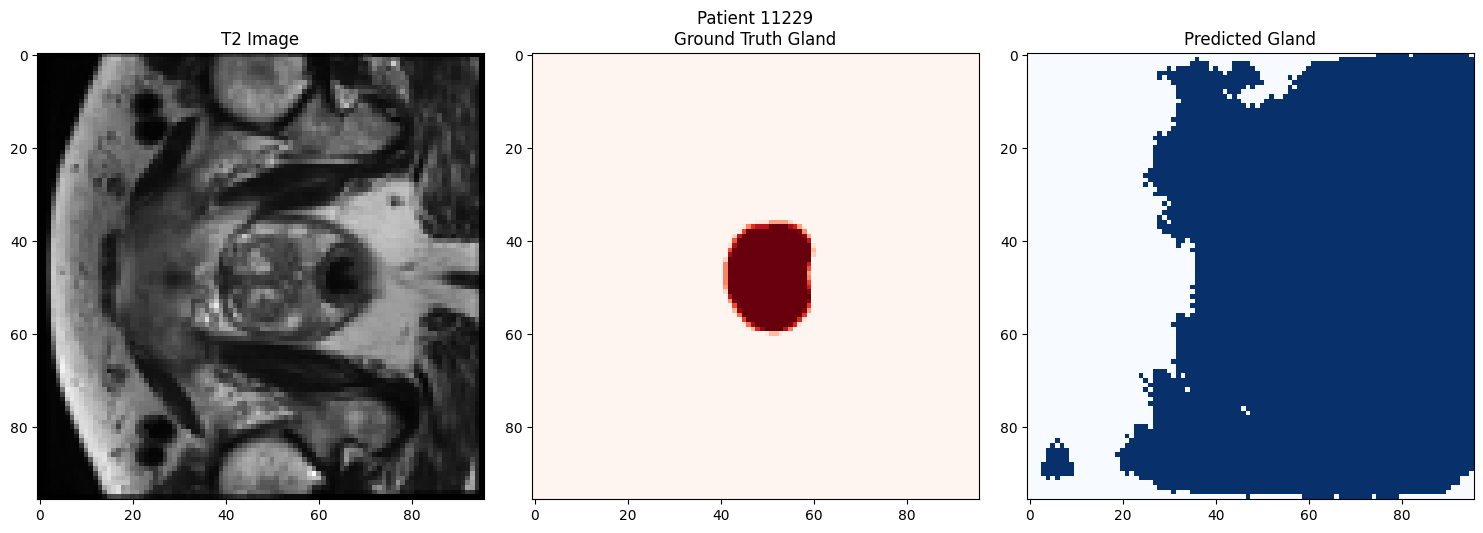

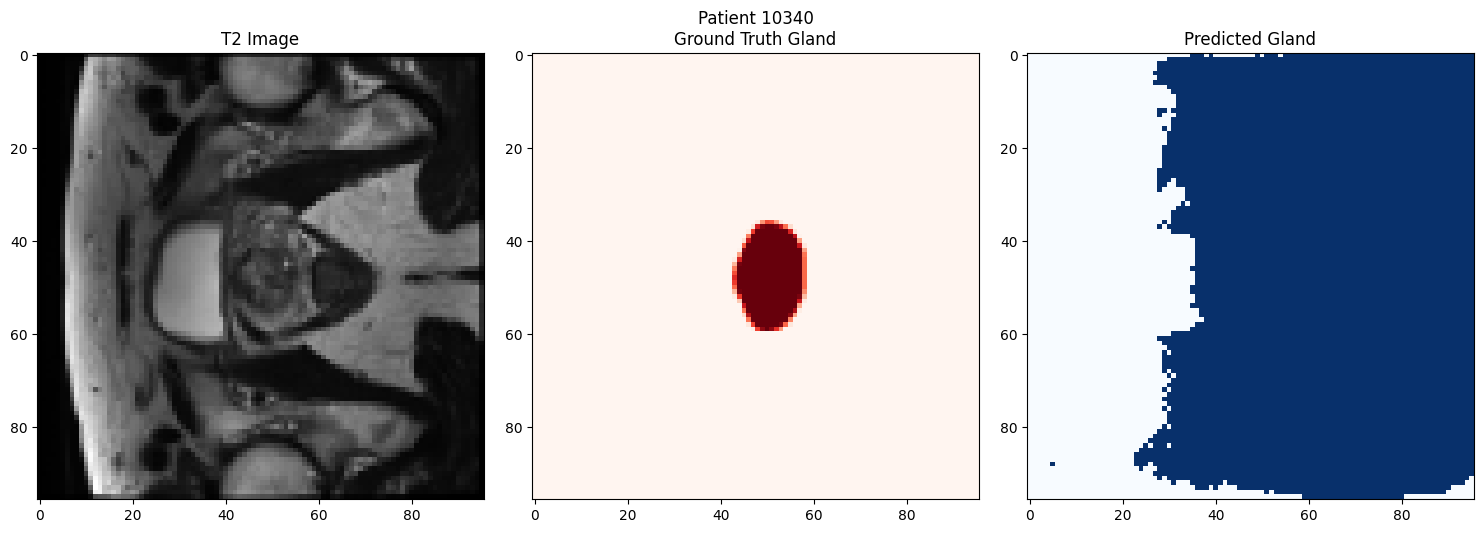

In [40]:
for pid in results_df.sort_values("dice").head(3)["patientID"]:
    visualize_prediction(pid)  # Worst 3

###  Analysis of Worst-Performing Predictions

The visualizations above highlight the three patients with the lowest Dice scores during evaluation on the D2 dataset. Despite achieving scores around 0.87–0.88, several important patterns emerge:

- **Over-segmentation**: The predicted gland masks (shown in blue) significantly overestimate the actual gland size and location. In some cases, large parts of the background are incorrectly labeled as gland tissue.
  
- **Mismatch in Shape and Location**: While the ground truth glands are small and compact (centered red masks), the predicted regions are more diffuse and irregular, lacking anatomical precision.

- **Class Imbalance Effect**: The gland occupies a small fraction of the total volume, making it susceptible to overprediction. Dice score, which is overlap-based, may still return a moderately high value even when large false positives are present.

- **Dice Score Limitations**: These examples underscore how Dice can sometimes be misleading—high overlap can mask the severity of overprediction errors if the union is also inflated.

**Takeaway**: Visual inspection remains critical. These results indicate the model could benefit from fine-tuning, class-balanced loss functions, or postprocessing strategies (e.g., connected component filtering) to suppress noisy or excessive predictions.


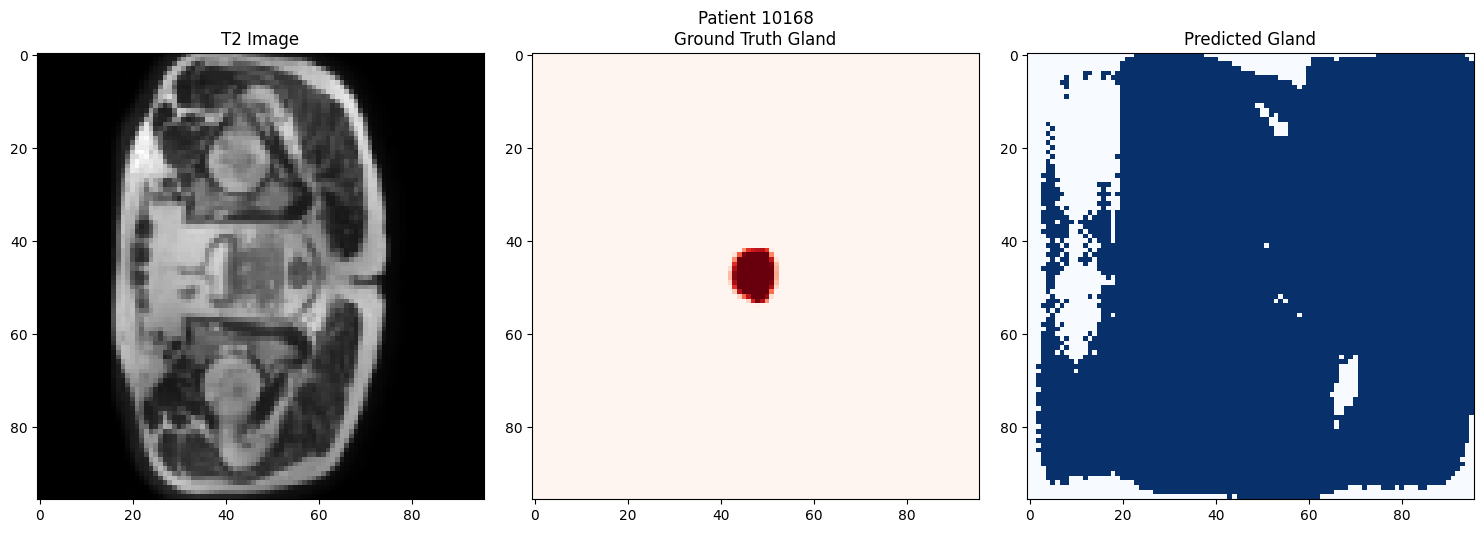

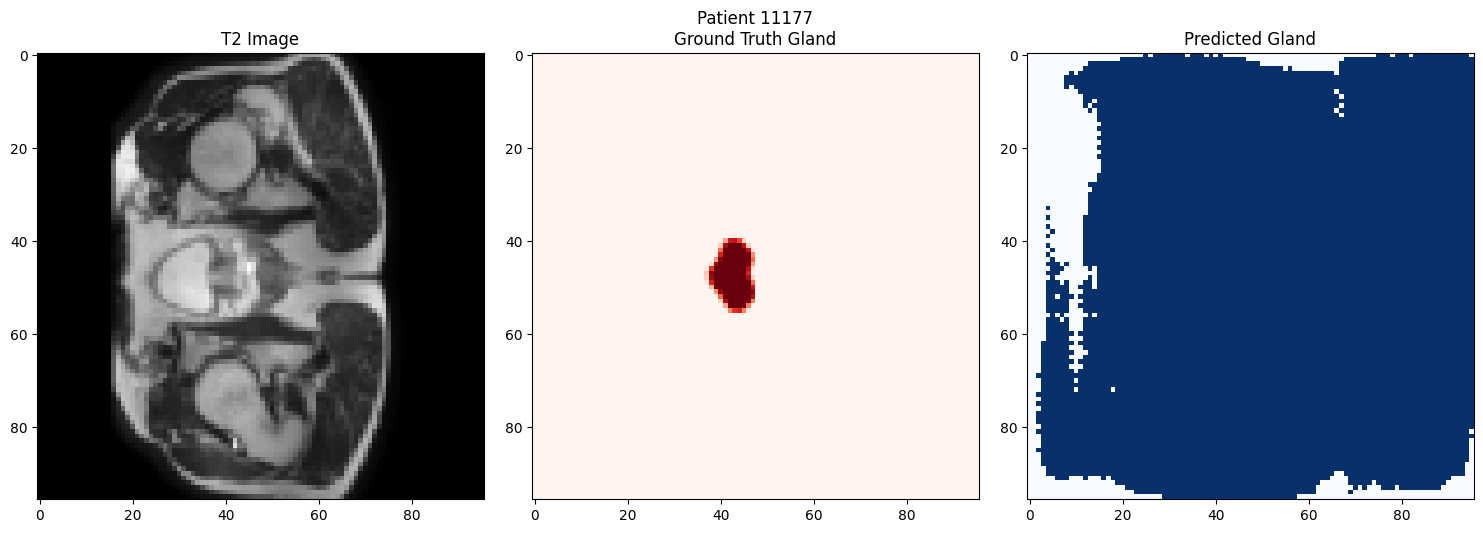

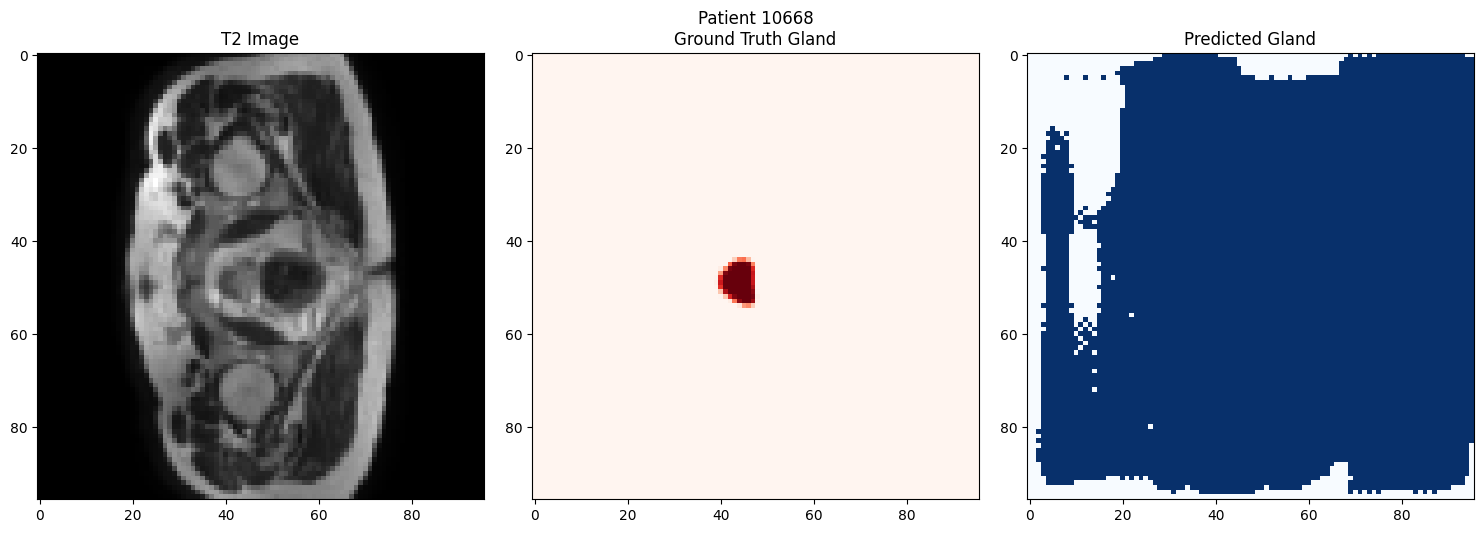

In [41]:
for pid in results_df.sort_values("dice", ascending=False).head(3)["patientID"]:
    visualize_prediction(pid)  # Best 3

### Best Performing Cases – Visualization Analysis

The figures above show the top 3 patients based on Dice scores. While the reported Dice values are relatively high (approximately 0.87–0.88), the visualizations reveal important issues:

- **Over-segmentation**: The predicted central gland masks are significantly overextended, covering areas beyond the actual gland regions.
- **Poor Localization**: The model struggles to correctly localize the gland, often identifying large background areas as part of the gland.
- **Limitations of Dice Score**: Although the Dice scores appear good, they can be misleading. The metric captures volume overlap but not the spatial accuracy of the prediction. As a result, predictions with incorrect shapes or positions may still score well.

These findings emphasize the importance of visual validation alongside metric-based evaluation. Improvements such as fine-tuning the model and applying post-processing may be necessary to enhance the anatomical precision of the predictions.
